## Week 7-8: Driving interior inspection
#### To ensure the safety of every trip, Uber is gradually promoting the installation of in-car cameras for drivers to record any unexpected situations that may occur while driving.
#### With the outbreak of COVID19, after the orderly restoration of social order, the device began to carry another safety function, namely the detection of whether the user's mask is worn correctly. Although the requirements for wearing masks are not so strict at present, it is still for the safety of passengers. If a user without a mask is detected, a warning sound will be issued to remind the user to wear a mask.
#### Mask detection is a very simple Classification/Object Detection task in the field of deep learning CV. However, the focus of this task is different. The algorithm needs to be able to complete an effective detection every 0.5 seconds without affecting the recording on a low-cost, low-performance embedded terminal device.
#### The in-car recorder uses Respberry Pi 3B+ as the performance benchmark. If you don't have the hardware, consider using a single-core virtual machine to run raspi os for debugging.
#### In the algorithm verification phase, we choose two different data sets. If you use the Classification method, use the Facemask Detection data set; if you use the Object Detection method, use Kaggle's https://www.kaggle.com/datasets/andrewmvd/face-mask-detection data set with anchors.
#### The picamera package was used for recording on the Raspberry Pi, and the deep learning framework was pytorch.

### Task
#### Regarding model selection, high-performance models include mobilenet, shufflenet, etc. For object detection, consider tiny yolo, PP-YOLOv2 or SSD. Accuracy is not the focus of this business.
#### After training the model, deploy it to RPI and run it continuously at least 30fps. When recording with Picamera, classification can be ensured without affecting the recording process.
#### Why is "an effective detection can be completed every 0.5 seconds" used in the project description above? Because in fact, the requirement does not require continuous operation on the video stream. It is completely acceptable to sample the image every 0.5 seconds and send the image to the neural network for inference to obtain the result.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix
import random
from xml.dom.minidom import parse
from PIL import Image
from IPython.display import display, Image as IPyImage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import time
import os

In [2]:
RETRAIN = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name()}")

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
def load_and_visualize_images(directory):
    jpg_files = [f for f in os.listdir(directory) if (f.endswith('.jpg') or f.endswith('.png'))]
    xml_files = [f for f in os.listdir(directory) if f.endswith('.xml')]

    mask_labels = []
    for xml_file in xml_files:
        xml_path = os.path.join(directory, xml_file)
        dom = parse(xml_path)

        folder_name = dom.getElementsByTagName("folder")[0].childNodes[0].data.split('/')[-1]
        label = 1 if folder_name[-5:] == '_mafa' else 0
        mask_labels.append(label)

    label_1_images = [jpg_files[i] for i in range(len(jpg_files)) if mask_labels[i] == 1]
    label_0_images = [jpg_files[i] for i in range(len(jpg_files)) if mask_labels[i] == 0]
    
    random.seed(42)
    image_1 = random.choice(label_1_images)
    image_0 = random.choice(label_0_images)

    print(f"Total images with mask (label 1): {len(label_1_images)}")
    print(f"Total images without mask (label 0): {len(label_0_images)}")

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    img_path_1 = os.path.join(directory, image_1)
    img_1 = Image.open(img_path_1)
    axes[0].imshow(img_1)
    axes[0].set_title(f"Mask Sample")
    axes[0].axis('off')

    img_path_0 = os.path.join(directory, image_0)
    img_0 = Image.open(img_path_0)
    axes[1].imshow(img_0)
    axes[1].set_title(f"No Mask Sample")
    axes[1].axis('off')

    plt.show()

    return mask_labels

In [4]:
class MaskDataset(Dataset):
    def __init__(self, root, labels, transforms=None):
        self.root = root
        self.labels = labels
        self.transforms = transforms
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg') or f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        label = self.labels[idx]

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Total images with mask (label 1): 3006
Total images without mask (label 0): 3126


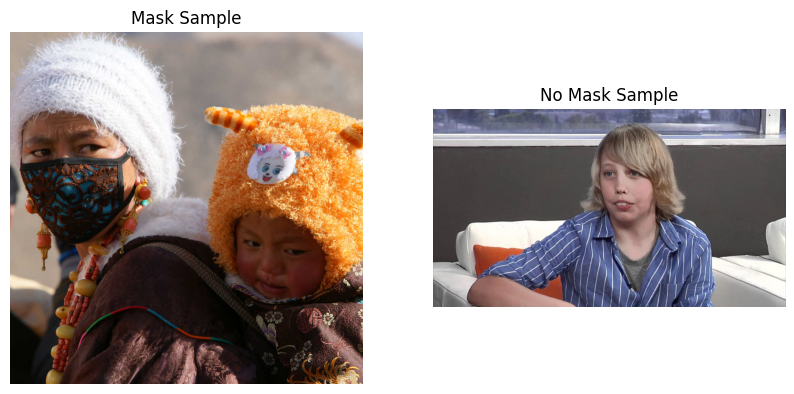

Total images with mask (label 1): 1059
Total images without mask (label 0): 780


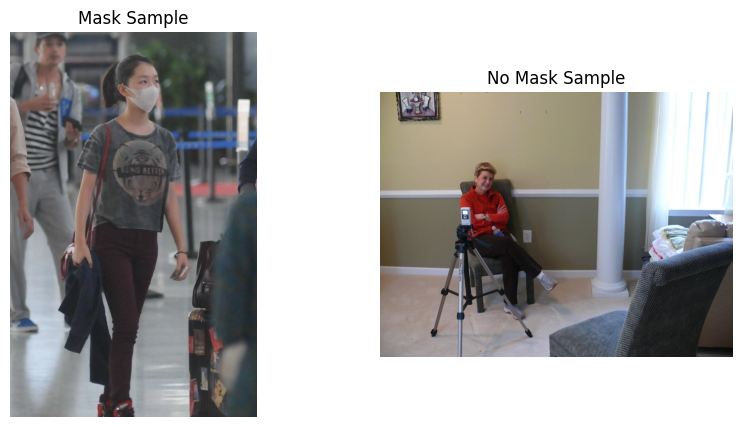

In [5]:
train_root = os.path.join('data', 'FaceMaskDataset', 'train')
val_root = os.path.join('data', 'FaceMaskDataset', 'val')

y_train = load_and_visualize_images(train_root)
y_test = load_and_visualize_images(val_root)

train_dataset = MaskDataset(root=train_root, labels=y_train, transforms=transform)
val_dataset = MaskDataset(root=val_root, labels=y_test, transforms=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [6]:
model_path = 'mask_detection.pth'

if os.path.isfile(model_path):
    print("Loading saved model...")
    model = torch.load(model_path)

else:
    print("No saved model found. Initializing a new model.")
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_val_loss = float("inf")
    early_stop_counter = 0
    patience = 3
    num_epochs = 5
    RETRAIN = True

Loading saved model...


In [7]:
def print_confusion_matrix(conf_matrix, class_names):
    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    print(df_cm)

class_names = ['No Mask', 'Mask']

if not RETRAIN:
    print("Evaluating...")

    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss /= len(val_loader.dataset)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

    print(f'Test Loss: {test_loss:.4f}')
    print("Confusion Matrix:")
    print_confusion_matrix(conf_matrix, class_names)

else:
    print("Training...")
    best_val_loss = float("inf")
    early_stop_counter = 0
    patience = 5
    num_epochs = 2 #20

    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_steps = len(train_loader)
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                val_loss += loss.item() * images.size(0)
                
                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss /= len(val_loader.dataset)

        conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print("Confusion Matrix:")
        print_confusion_matrix(conf_matrix, class_names)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model, model_path)
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        lr_scheduler.step()

Evaluating...
Test Loss: 0.1181
Confusion Matrix:
         No Mask  Mask
No Mask      745    35
Mask          50  1009


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def detect_mask(frame):
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        label = preds.item()
    
    return label

In [9]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    start_time = time.time()
    label = detect_mask(frame)
    elapsed_time = time.time() - start_time

    if label == 0:
        text = "No Mask"
        color = (0, 0, 255)
    else:
        text = "Mask"
        color = (0, 255, 0)

    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    instructions = "Press 'q' or 'Esc' to exit"
    instructions_background = (0, 0, 0)
    instructions_color = (255, 255, 255)
    font_scale = 0.7
    thickness = 2

    (text_width, text_height), _ = cv2.getTextSize(instructions, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    text_x, text_y = 10, frame.shape[0] - 10
    box_x1, box_y1 = text_x - 5, text_y - text_height - 5
    box_x2, box_y2 = text_x + text_width + 5, text_y + 5

    cv2.rectangle(frame, (box_x1, box_y1), (box_x2, box_y2), instructions_background, -1)
    cv2.putText(frame, instructions, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, instructions_color, thickness)

    cv2.imshow("Mask Detection", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or key == 27:
        break

cap.release()
cv2.destroyAllWindows()